# The AirBnB dataset

<img src="https://www.esquireme.com/public/images/2019/11/03/airbnb-678x381.jpg" alt="airbnb" width="400"/>

[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In the first three exercises you will use Spark to analyze data obtained from the Airbnb website (stricly speaking via data scraped by [insideairbnb](http://insideairbnb.com/get-the-data.html)). The purpose of your analysis is to extract insights about listings as a whole, specifics about London, and sentiment analysis of reviews (word positivity).


## Loading data
The dataset consists of listings (offered lodgings) and reviews (submitted by users). The `.csv`'s we'll work with vary between the first three exercises, but is structured so that the function below will load it into a spark dataframe.

In [1]:
def load_csv_as_dataframe(path):
    return spark.read.option('header', True) \
                .option('inferSchema', True) \
                .option('multiLine', 'True') \
                .option('escape', '"') \
                .option('mode', 'DROPMALFORMED')\
                .csv(path)

## Imports and Spark session


In [1]:
# 1) Install pyspark via conda/pip
#          pyspark requires the JAVA_HOME environment variable is set.
# 2) Install JDK 8 or 11, figure out the install location
#          Suggest to use https://adoptopenjdk.net/
# 3) Update the JAVA_HOME environment variable set programmatically below 
#    with your install location specifics

# JAVA_HOME environment variable is set programatically below
# but you must point it to your local install

import os
# os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jre1.8.0_202'

# If you get "Job aborted due to stage failure" and 
# "Python worker failed to connect back." exceptions, 
# this should be solved by additionally setting these 
# environment variables

os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'notebook'

In [3]:
#os.environ['HADOOP_HOME'] 

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark import SparkContext, SparkConf
from pyspark.sql.window import Window
from pyspark.sql import SQLContext

from pandas_profiling import ProfileReport

import pandasql as psql
#pyspark.sql.types.DoubleType

In [4]:
# Sets memory limit on driver and to use all CPU cores
conf = SparkConf().set('spark.ui.port', '4050') \
        .set('spark.driver.memory', '4g') \
        .setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

In [6]:
sc.getConf().getAll()

[('spark.driver.memory', '4g'),
 ('spark.app.startTime', '1638135203356'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '53499'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/MaClo/OneDrive/Course/dataScience/p2/spark-warehouse'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.host', 'DESKTOP-0GTOON0'),
 ('spark.ui.port', '4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1638135204777')]

# Data Processing


## Part 1: Preparing the dataframe

Our data source is [this zip archive](https://data-download.compute.dtu.dk/c02807/listings.csv.zip) which we uncompress and place in the same folder as this notebook. It is loaded in the next cell and named `df_listings`.

After the data is read, we should select the necessary columns and name this dataframe `df_listings_analysis` and make use of caching.

Prices are in local currency, but are nonetheless prefixed with `$` and contains thousands separator commas. You will need to remove these characters and cast the price column to `pyspark.sql.types.DoubleType`. Observe that if this casting is not possible, the result of the cast is `null`.

In [8]:
df_listings = load_csv_as_dataframe('listings.csv')

In [9]:
#select useful columns:
df_listings_analysis = df_listings.select('id', 'price', 'city', 'neighbourhood_cleansed', 'property_type', \
                                          'review_scores_rating').cache()
#remove'$' and ',' and cast to double:
clean_price = F.translate(F.col("price"), "$,", "").cast(DoubleType()).alias("price")
df_listings_analysis = df_listings_analysis.withColumn('price', clean_price)
df_listings_analysis.toPandas().head(5)

,id,price,city,neighbourhood_cleansed,property_type,review_scores_rating
0,145320,1272.0,Stockholm,Södermalms,Apartment,97
1,155220,1203.0,Stockholm,Skarpnäcks,House,None
2,155685,3209.0,Stockholm,Södermalms,Apartment,94
3,164448,597.0,Stockholm,Södermalms,Apartment,97
4,170651,734.0,Stockholm,Södermalms,Apartment,93


## Part 2: Listing and neighbourhood counts

Compute and visualise the number of listings and the number of different neighbourhoods per city, restricted to the 15 cities having the most listings. The x-axis should be ordered by number of listings (high to low).

Make sure to use the `neighbourhood_cleansed` column in your computations.


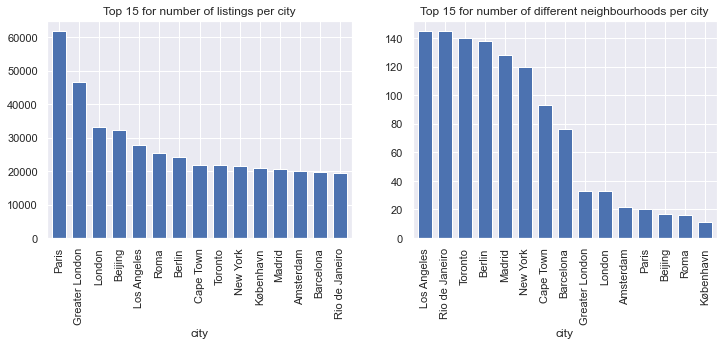

In [61]:
# get the number of listings per city:
df_list_city = df_listings_analysis.groupBy('city')\
                                   .count()\
                                   .sort(F.desc('count'))\
                                   .limit(15)

# get the number of different neighbourhoods per city:
df_neigh_city = df_listings_analysis.groupBy('city')\
                                    .agg(F.count('*').alias('count'), F.countDistinct('neighbourhood_cleansed').alias('neighbour_city'))\
                                    .sort(F.desc('count'))\
                                    .limit(15)\
                                    .sort(F.desc('neighbour_city'))

# visualization:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
df_list_city.toPandas().plot(x='city', y='count', kind='bar', width=0.7, legend=False, ax = axis[0])
axis[0].set_title('Top 15 for number of listings per city')
df_neigh_city.toPandas().plot(x='city', y='neighbour_city', kind='bar',width=0.7, legend=False, ax = axis[1])
_ = axis[1].set_title('Top 15 for number of different neighbourhoods per city')

## Part 3: Price averages

Compute and visualise the average price of listings per city, restricted to the 15 cities having the most listings.

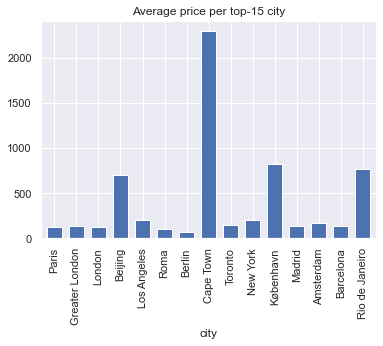

In [11]:
df_avg_price = df_listings_analysis.groupBy('city').agg(F.count('*').alias('count'), F.avg('price'))\
                                    .orderBy('count', ascending=False).limit(15)

df_avg_price.toPandas().plot(x='city', y='avg(price)', kind='bar', width=0.7, legend=False)
_ = plt.title('Average price per top-15 city')

## Part 4: Value for money

The value of a listing is its rating divided by its price. The value of a city is the average value of its listings. 

Prices are only comparable when the local currency is the same. We'll therefore consider a subset of Euro-zone cities as defined in `eurozone_cities`.

Compute and visualise the value per city, restricted to the Euro-zone cities.

In [12]:
eurozone_cities = [
    'Paris', 'Roma', 'Berlin', 'Madrid', 'Amsterdam', 'Barcelona', 'Milano', 'Lisboa',
    'München', 'Wien', 'Lyon', 'Firenze', 'Porto', 'Napoli', 'Bordeaux', 'Venezia',
    'Málaga', 'Sevilla', 'València'
]

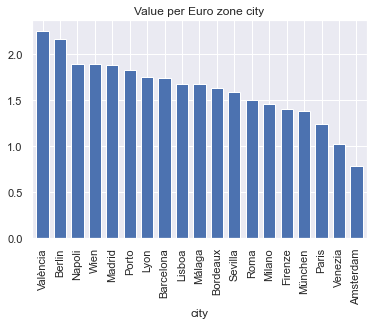

In [13]:
# filter Euro zone, then compute value.
df_listings_euro = df_listings_analysis.where(F.col('city').isin(eurozone_cities))
df_listings_euro = df_listings_euro.withColumn('value', F.col('review_scores_rating') / F.col('price'))
df_avg_value = df_listings_euro.groupBy('city').agg(F.avg('value')).orderBy('avg(value)', ascending=False)
# visualization:
df_avg_value.toPandas().plot(x='city', y='avg(value)', kind='bar', width=0.7, legend=False)
_ = plt.title('Value per Euro zone city')

# The case of London

In this exercise you must use Spark to do the data processing. 
* For parts where you present tabular data, this entails calling `toPandas` as the final step of your query. 
* For parts requiring visualisation, the `toPandas` call should be followed only by functions necessary to customize the plotting/layout steps (i.e. no data processing take place after your spark dataframe is materialized). 
* You may need multiple queries to solve the individual parts.

Your dataframe is a subset of `df_listings_analysis` and should be named `df_listings_london`.

In [14]:
df_listings_london = df_listings_analysis.where(F.col('city') == 'London')

## Part 1: Price distribution

Compute and visualise the distribution of prices, for all prices up to and including the 95-percentile. Additionally, compute and visualise the distribution of prices, for all prices above the 95-percentile.

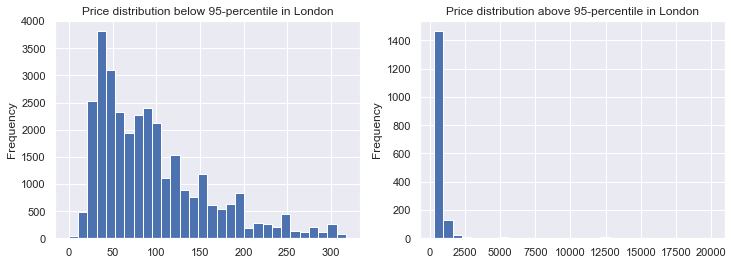

In [15]:
# get data subset repectively
price_95 = df_listings_london.select(F.percentile_approx("price", 0.95)).head()[0]
below_95 = df_listings_london.where(F.col('price') <= price_95)
above_95 = df_listings_london.where(F.col('price') > price_95)

# visualise the distribution
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
below_95.toPandas().plot(x='city', y='price', kind='hist', legend=False, bins=30, ax = axis[0])
axis[0].set_title('Price distribution below 95-percentile in London')
above_95.toPandas().plot(x='city', y='price', kind='hist', legend=False, bins=30, ax = axis[1])
_ = axis[1].set_title('Price distribution above 95-percentile in London')

## Part 2: Prices by type of property

Compute and visualise the average price and average rating per type of property, for property types with 75 or more listings. 

Your visualisation should be a single bar chart with two y-axes and two bars per property type. The x-axis should be ordered by average rating.

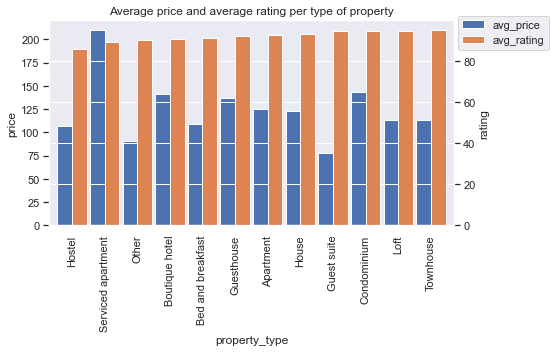

In [16]:
# compute average price and average rating per type of property:
price_rating = df_listings_london\
                .groupBy('property_type')\
                .agg(F.avg('price').alias('avg_price'), F.avg('review_scores_rating').alias('avg_rating'), F.count('*').alias('count'))\
                .orderBy('avg_rating')\
                .where(F.col('count') >= 75)

# visualization:
price_rating = price_rating.toPandas().set_index('property_type').drop('count', axis=1)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_ = price_rating.plot.bar(secondary_y= 'avg_rating', width=0.9, ax=ax, legend=False)
ax.set_title('Average price and average rating per type of property')
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylabel('price'); ax2.set_ylabel('rating')
fig.legend(bbox_to_anchor=(1.1, 0.95)); fig.tight_layout()

## Part 3: Best offering in the neighbourhood

The value of a listing is its rating divided by its price. Compute and display a dataframe (with the columns you selected in Exercise 1 and those computed in this part) with the 3 highest valued listings in each neighbourhood, and having a value above 5. Make sure to use the `neighbourhood_cleansed` column in your computations.

Computing ranks based on value can be achieved using `pyspark.sql.window.Window`. This may produce equal ranks (i.e. when the value of two listings are the same).

Remember to use `pd.set_option('display.max_rows', <n>)` with appropriate `<n>` so all rows are displayed.

In [17]:
# rank for each neighbourhood based on value
df_listings_london = df_listings_london.withColumn('value', F.col('review_scores_rating') / F.col('price'))
windowSpec  = Window.partitionBy("neighbourhood_cleansed").orderBy(F.desc("value"))
df_london_rank = df_listings_london.withColumn("rank",F.row_number().over(windowSpec))
# show the result
pd.set_option('display.max_rows', None)
df_london_rank.where((F.col('rank') <= 3) & (F.col('value') >=5)).toPandas()

,id,price,city,neighbourhood_cleansed,property_type,review_scores_rating,value,rank
0,7208317,18.0,London,Croydon,House,92,5.111111,1
1,8420459,19.0,London,Croydon,Apartment,97,5.105263,2
2,14217336,20.0,London,Croydon,Apartment,100,5.000000,3
3,13504236,15.0,London,Wandsworth,House,100,6.666667,1
4,16633233,15.0,London,Wandsworth,Apartment,100,6.666667,2
5,22512980,16.0,London,Wandsworth,Apartment,95,5.937500,3
6,20232084,15.0,London,Lambeth,Apartment,99,6.600000,1
7,15037827,17.0,London,Lambeth,Apartment,95,5.588235,2
8,3573976,18.0,London,Lambeth,Apartment,95,5.277778,3
9,24979813,16.0,London,Camden,Hostel,90,5.625000,1


## Part 4: Activity by month

Activity is given by the number of reviews received in a given time period. Compute and visualise the activity based on month, that is, the total number of reviews given in January, February, etc..

Your additional data source is [this zip archive](https://data-download.compute.dtu.dk/c02807/reviews_london.csv.zip) which you must uncompress and place in the same folder as this notebook. It is loaded in the next cell and named `df_reviews_london`.

In [18]:
df_reviews_london = load_csv_as_dataframe('reviews_london.csv')

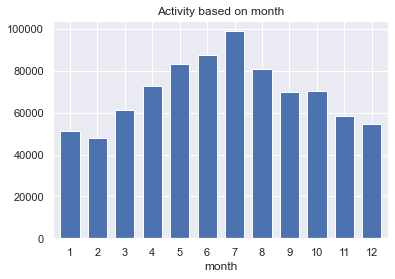

In [19]:
# add 'month' column then count
df_reviews_london = df_reviews_london.withColumn('month', F.month('date'))
df_reviews_monthCount = df_reviews_london.groupBy('month').count().orderBy('month')
# visualization:
df_reviews_monthCount.toPandas().plot(x='month', y='count', kind='bar', width=0.7, legend=False)
plt.title('Activity based on month'); _ = plt.xticks(rotation=0)

## Part 5: Reviews per listing

Each London listing has received 0 or more reviews. 

Display a dataframe showing 1) The number of listings, 2) The average number of reviews a listing receives, 3) The standard deviation of the reviews per listing distribution, 4) The minimum number of reviews any listing has received, and 5) The maximum number of reviews any listing has received.

In [20]:
df_list_review = df_listings_london.join(df_reviews_london.select('listing_id'), \
                                         df_reviews_london['listing_id'] == df_listings_london['id'])
list_count = df_list_review.groupBy('id').count()
list_count.select(\
        F.count('id').alias('number of listings'),\
        F.round(F.avg('count'), 2).alias('avg_reviews'),\
        F.round(F.stddev('count'), 2).alias('std_reviews'),\
        F.round(F.min('count'), 2).alias('min_reviews'),\
        F.round(F.max('count'), 2).alias('max_reviews')).toPandas()

,number of listings,avg_reviews,std_reviews,min_reviews,max_reviews
0,25920,32.27,50.88,1,690


# Word sentiment

In this exercise you must use Spark to do the data processing. For parts where you present tabular data, this entails calling `toPandas` as the final step of your query. You may need multiple queries to solve the individual parts.

The goal here is to determine what sentiment (positive or negative) words in reviews have. Roughly speaking, we want each word to be assigned a score based on the rating of the reviews in which the word occurs in the review comment. We'd expect words such as "clean", "comfortable", "superhost" to receive high scores, while words such as "unpleasant", "dirty", "disgusting" would receive low scores.

As individual reviews do not have a rating, we'll consider the rating of individual reviews to be the rating of its related listing (i.e. assuming each review gave the average rating (`review_scores_rating`) of the listing). 

The score of a word is given by the mean review rating over the reviews in which that word occurs in the comment. We require words to appear in at least 0.5% (1 in 200) listings, and to be at least 4 characters, for it to have a defined score.

Formally, when a word $w$ occurs in at least $0.5\%$ of listings and $|w| > 3$, its score is

$
\begin{align*}
score(w) = \frac{1}{|C_w|}\sum_{comment \in C_w} \text{review_rating}(comment)
\end{align*}
$
, where 
* $C_w = \{comment \mid w \text{ occurs in } \text{clean_text}(comment)\}$, the set (so no duplicates) of comments in which $w$ occurs, and
* $\text{clean_text}(comment)$ is the result of your `clean_text` function defined below, and
* $\text{review_rating}(comment)$ is the `review_scores_rating` of the listing which this $comment$ is related to.


## Part 1: Toy data

To get started we'll consider a toy example where the input is `df_sentiment_listings_toy` and `df_sentiment_reviews_toy` defined in the next code cell. You should provide an implementation of `calculate_word_scores_toy` in the subsequent code cell. Your implementation should result in a query that when given the toy example dataframes as input and is materialized with `toPandas()` produces this table:

|    | word   |   word_score |   listing_occurences |   word_occurences |   comment_occurences |
|---:|:-------|-------------:|---------------------:|------------------:|---------------------:|
|  0 | aaaa   |      7       |                    3 |                 5 |                    5 |
|  1 | bbbb   |      6.66667 |                    2 |                 3 |                    3 |
|  2 | eeee   |      0       |                    1 |                 1 |                    1 |
|  3 | dddd   |      5       |                    1 |                 1 |                    1 |
|  4 | cccc   |      5       |                    2 |                 2 |                    2 |'

Observe that `word_occurences` and `comment_occurences` are the same as words occuring multiple times in a comment are counted once, and that `clean_text` is used to ignore casing and discard non-words. Additionally, any word occuring at least once will occur in more than 1 out of 200 listings on this toy data.

In [21]:
from pyspark.sql.types import StructType, StructField, StringType

schema_listings = StructType([
    StructField('id', StringType(), True),
    StructField('review_scores_rating', StringType(), True),
])
data_listings = [
    {'id': '0', 'review_scores_rating': '10'},
    {'id': '1', 'review_scores_rating': '5'},
    {'id': '2', 'review_scores_rating': '0'},
]
df_sentiment_listings_toy = spark.createDataFrame(data_listings, schema_listings)

schema_reviews = StructType([
    StructField('listing_id', StringType(), True),
    StructField('id', StringType(), True),
    StructField('comments', StringType(), True),
])
data_reviews = [
    {'listing_id': '0', 'id': '100', 'comments': 'aaaa bbbb          cccc'},
    {'listing_id': '0', 'id': '101', 'comments': 'aaaa bbbb '},
    {'listing_id': '0', 'id': '102', 'comments': 'aaaa aAAa          aaaa'},
    {'listing_id': '1', 'id': '103', 'comments': 'Aaaa bbb ccc'},
    {'listing_id': '1', 'id': '104', 'comments': 'dddd %ˆ&*'},
    {'listing_id': '2', 'id': '105', 'comments': 'AaaA'},
    {'listing_id': '2', 'id': '106', 'comments': 'bbbb ccc e&eˆˆee'},
    {'listing_id': '2', 'id': '107', 'comments': 'cccc cccc'},
]

df_sentiment_reviews_toy = \
    spark.createDataFrame(data_reviews, schema_reviews) \
        .select(F.col('listing_id'), F.col('id').alias('comment_id'), F.col('comments'))

In [22]:
def clean_text(col):
    """
        Cleans the text (comment) associated with col. The
        cleaning should:
            1) Lower case the text
            2) Turn multiple whitespaces into single whitespaces
            3) Remove anything but letters, digits and whitespaces
        
        :col: A Spark Column object containing text data
        :returns: A Spark Column object.
    """
    return F.regexp_replace(F.regexp_replace(F.lower(col), '\s+', ' '), '[^a-zA-Z\d\s]', '')
    raise NotImplementedError

def calculate_word_scores_toy(df_list, df_rev):
    """
        Calculates the word score over listings in df_list and
        reviews in df_rev. The table produced should have the 
        same columns as specified in part 1.
        
        :returns: A pandas DataFrame
    """
    # clean the df_rev:
    df_rev_clean = df_rev.withColumn('comments', clean_text('comments'))
    df_listings_reviews = df_list.join(df_rev_clean, df_list['id'] == df_rev_clean['listing_id'])
    
    # explode the column comment, one word per line:
    df_explode = df_listings_reviews.withColumn('word',F.explode(F.split('comments',' '))).dropDuplicates()
    df_stats = df_explode.groupBy('word').agg(F.avg('review_scores_rating').alias('word_score'),\
                                                F.countDistinct('listing_id').alias('listing_occurences'),\
                                                F.count('*').alias('word_occurences'),\
                                                F.countDistinct('comment_id').alias('comment_occurences'))
    
    # filter the word occurs in at least 0.5% of listings and len(word) > 3
    listing_num_least = df_list.count() * 0.005
    df_final = df_stats.filter((df_stats["word"].rlike('\w\w\w\w+')) & (df_stats['listing_occurences']>listing_num_least))
    
    return df_final.toPandas()
    raise NotImplementedError

calculate_word_scores_toy(df_sentiment_listings_toy, df_sentiment_reviews_toy)

,word,word_score,listing_occurences,word_occurences,comment_occurences
0,aaaa,7.000000,3,5,5
1,bbbb,6.666667,2,3,3
2,eeee,0.000000,1,1,1
3,dddd,5.000000,1,1,1
4,cccc,5.000000,2,2,2


## Part 2: London comments

In this part we'll calculate word scores for the comments related to London listings only. You should implement `count_relevant_listings` and `calculate_word_scores` (it will be an extension of your function from part 1) below. See the mathematical definition and docstrings for intended behaviour.

The function `calculate_word_scores` should return the top 10 and bottom 10 words by score. You should **not** use caching in your function.

Make sure your satisfy all conditions for a word to be scored (e.g. correctly calculating how many total listings scores are computed over). You should also consider whether your query is optimally structured in terms of computation time. Moreover, `pd.set_option('display.max_rows', <n>)` should be set with sufficiently high `n` to show all words.

In [23]:
def count_relevant_listings(df_list, df_rev):
    """
        Calculates the number of listings in df_list that has a 
        review in df_rev. A listing that is reviewed more than once
        should only count as one.
        
        :returns: An integer 
    """
    df_list_review = df_list.select('id').join(df_rev.select('listing_id'),df_list['id'] == df_rev['listing_id'])
    return df_list_review.select(F.countDistinct('listing_id')).head()[0]
    
    raise NotImplementedError

def calculate_word_scores(df_list, df_rev, listings_count):
    """
        Calculates the word score over listings in df_list and
        reviews in df_rev. The value of listings_count should 
        be used to filter out words not occuring frequently enough
        in comments. The table produced should have the same columns
        as in part 1 of this exercise.
        
        :returns: A pandas DataFrame containing the top 10 and 
        bottom 10 words based on their word score, sorted by word_score.
    """
    # clean the df_rev:
    df_rev_clean = df_rev.withColumn('comments', clean_text('comments'))
    df_listings_reviews = df_list.select('id', 'review_scores_rating')\
                                 .join(df_rev_clean.select('listing_id', F.col('id').alias('comment_id'), 'comments'),\
                                       df_list['id'] == df_rev_clean['listing_id'])
    
    # explode the column comment, one word per line:
    df_explode = df_listings_reviews.withColumn('word',F.explode(F.split('comments',' '))).dropDuplicates()
    df_stats = df_explode.groupBy('word').agg(F.avg('review_scores_rating').alias('word_score'),\
                                                F.countDistinct('listing_id').alias('listing_occurences'),\
                                                F.count('*').alias('word_occurences'),\
                                                F.countDistinct('comment_id').alias('comment_occurences'))
    
    # filter the word occurs in at least 0.5% of listings and len(word) > 3
    listing_num_least = listings_count * 0.005
    df_final = df_stats.filter((df_stats["word"].rlike('\w\w\w\w+')) & (df_stats['listing_occurences']>listing_num_least))
    
    # find top-10 and bottom-10 words then union them, then sort
    df_top = df_final.sort(df_final['word_score'].desc()).limit(10)
    df_bot = df_final.sort(df_final['word_score']).limit(10)
    df = df_top.union(df_bot).sort(F.col('word_score'), ascending=False)
    
    return df.toPandas()
    raise NotImplementedError

In [159]:
# should not be modified
from IPython.display import display

relevant_listings_count_london = count_relevant_listings(df_listings_london, df_reviews_london)
word_scores_london_timing = %timeit -o -n1 -r1 display( \
    calculate_word_scores(df_listings_london, \
                          df_reviews_london, \
                          relevant_listings_count_london) \
)

word_scores_london_timing.best

,word,word_score,listing_occurences,word_occurences,comment_occurences
0,granola,97.553279,153,244,244
1,homemade,97.267500,474,1200,1200
2,superhost,97.057178,687,822,822
3,yogurt,97.054264,245,387,387
4,yoghurt,97.037037,146,216,216
5,baked,96.942593,296,540,540
6,muesli,96.897727,180,264,264
7,lovelier,96.863636,130,132,132
8,divine,96.800000,164,180,180
9,jane,96.747204,131,1788,1788


3min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


188.08127899999818

## Part 3: Scalability

The listings from London make up a little less than 2% of the entire set of listings. In this part we're interested in how the amount of input data impacts computation time, that is, how `calculate_word_scores` scales as data increases. To this end, we've made multiple samples of the dataset of varying sizes.

The experiment reuses `count_relevant_listings` and `calculate_word_scores` that you implemented in part 2. Code needed for this part is provided to you. 

Your task is to obtain the data sources, run the code cells below, and explain the results you get. Specifically, you must explain any non-linear relationship between data size and computation time, using the markdown cell at the end of this part. In finding explanations, using the Spark UI to investigate the anatomy of your queries may prove valuable. Once you've found an explanation, state a potential solution to remedy the issue. Lastly, include a paragraph stating the specifications of your computer hardware (memory, CPU cores and clock speed, solid state disk or not) on which the experiment has been run.

*Implementation note* Make sure you've properly configured `spark.driver.memory` (it requires a kernel restart to update the value). It may be that your query fails on the larger samples due to running out of compute resources. This is likely caused by a suboptimal `calculate_word_scores`, but can be from reaching the limits of your hardware. If you think the latter is the case, argue for this perspective in the markdown cell.

Your data sources are (uncompress and place in the same directory as this notebook):
* 0.25%: [listings](https://data-download.compute.dtu.dk/c02807/listings_0-dot-25percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_0-dot-25percent.csv.zip)
* 0.5%: [listings](https://data-download.compute.dtu.dk/c02807/listings_0-dot-5percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_0-dot-5percent.csv.zip)
* 1%: [listings](https://data-download.compute.dtu.dk/c02807/listings_1-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_1-dot-0percent.csv.zip)
* 2%: [listings](https://data-download.compute.dtu.dk/c02807/listings_2-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_2-dot-0percent.csv.zip)
* 4%: [listings](https://data-download.compute.dtu.dk/c02807/listings_4-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_4-dot-0percent.csv.zip)
* 8%: [listings](https://data-download.compute.dtu.dk/c02807/listings_8-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_8-dot-0percent.csv.zip)
* 12.5%: [listings](https://data-download.compute.dtu.dk/c02807/listings_12-dot-5percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_12-dot-5percent.csv.zip)
* 16%: [listings](https://data-download.compute.dtu.dk/c02807/listings_16-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_16-dot-0percent.csv.zip)
* 25%: [listings](https://data-download.compute.dtu.dk/c02807/listings_25-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_25-dot-0percent.csv.zip)
* 50%: [listings](https://data-download.compute.dtu.dk/c02807/listings_50-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_50-dot-0percent.csv.zip)
* 75%: [listings](https://data-download.compute.dtu.dk/c02807/listings_75-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_75-dot-0percent.csv.zip)
* 100%: [listings](https://data-download.compute.dtu.dk/c02807/listings_100-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_100-dot-0percent.csv.zip)

In [24]:
import time
def calculate_word_scores_timed(percent_str):
    """
        Calculates word scores over a sampled dataset indicated
        by percent_str.
        
        :returns: A dictionary with benchmarking information and
        the calculated values.
    """
    df_listings = load_csv_as_dataframe(f'listings_{percent_str}percent.csv')
    df_reviews = load_csv_as_dataframe(f'reviews_{percent_str}percent.csv')
    
    listings_count = count_relevant_listings(df_listings, df_reviews)

    start = time.time()
    df_word_scores = calculate_word_scores(df_listings, df_reviews, listings_count)
    end = time.time()
    return {
        'percentage': float(percent_str.replace('-dot-', '.')), 
        'time_spent': f"{end - start:.2f}", 
        'relevant_listings': listings_count, 
        'df': df_word_scores
    }

In [25]:
data_percentages = [
    '0-dot-25', '0-dot-5', '1-dot-0', '2-dot-0', '4-dot-0', '8-dot-0',
    '12-dot-5', '16-dot-0', '25-dot-0'
]
score_data = {
    percentage_str: calculate_word_scores_timed(percentage_str) for percentage_str in data_percentages
}

In [28]:
score_data['50-dot-0'] = calculate_word_scores_timed('50-dot-0')

In [29]:
score_data['75-dot-0'] = calculate_word_scores_timed('75-dot-0')

In [30]:
score_data['100-dot-0'] = calculate_word_scores_timed('100-dot-0')

In [31]:
df_scores_scaling = pd.DataFrame(score_data).T.convert_dtypes()
df_scores_scaling.time_spent = df_scores_scaling.time_spent.astype(float)

# Access to word scores of 2 percent data: df_scores_scaling.loc['2-dot-0'].df
df_scores_scaling

,percentage,time_spent,relevant_listings,df
0-dot-25,0.25,74.87,2529,word word_score listing_occurences ...
0-dot-5,0.50,118.25,5040,word word_score listing_occure...
1-dot-0,1.00,184.32,10143,word word_score listing_occurence...
2-dot-0,2.00,323.21,20575,word word_score listing_occurences...
4-dot-0,4.00,666.66,40919,word word_score listing_occure...
8-dot-0,8.00,507.08,81756,word word_score listing_occure...
12-dot-5,12.50,778.83,128202,word word_score listing_occure...
16-dot-0,16.00,973.16,163627,word word_score listing_occure...
25-dot-0,25.00,1532.05,256183,word word_score listing_occure...
50-dot-0,50.00,3363.35,511667,word word_score listing_occure...


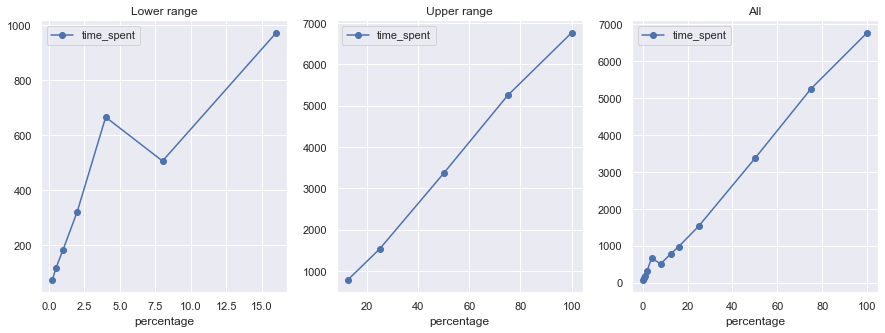

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

lower_range = ['0-dot-25', '0-dot-5', '1-dot-0', '2-dot-0', '4-dot-0', '8-dot-0', '16-dot-0']
df_scores_scaling[df_scores_scaling.index.isin(lower_range)] \
    .plot.line(x='percentage', y='time_spent', ax=axes[0], style='-o', title='Lower range')
df_scores_scaling[~df_scores_scaling.index.isin(lower_range)] \
    .plot.line(x='percentage', y='time_spent', ax=axes[1], style='-o', title='Upper range')
_ = df_scores_scaling \
    .plot.line(x='percentage', y='time_spent', ax=axes[2], style='-o', title='All')

*Your explanation to the questions outlined at the start of this part goes here. Make sure you've addressed all questions asked.*

**In our plot, we can clearly see that there is a down-trend in time-spent for dataset 8.0. Besides, the slope before the point 8.0 is higher than that after 8.0. We thought that's because when the naughts dataframe (listing) is small, spark use Broadcast Hash Join which needs to copy naughts dataframe to every executor so the efficiency would be small. When the both dataframes are large, spark would use Shuffle Merge Sort Join, which will have higher efficiency. We can change the parameter `spark.sql.autoBroadcastJoinThreshold` to a very small value if we want to remedy this case. We didn't validate that due to hardware limitation.**

**Memory: 8G**\
**CPU cores: 4 cores, 8 threads**\
**clock speed： 1.60GHz~1.80 GHz**\
**disk: yes**

## Part 4: Robustness

In this part we'll explore robustness of our word scores, using the values we computed in part 3. We'll do so by comparing top/bottom words for three different samples of the dataset. Specifically, the scores from your maximum (e.g. 100%) computed sample are to be compared with the 12.5% and 2.0% scores.

Compute and display a dataframe that accounts for any word found in either of the three samples' top/bottom words, and additionally shows the related `word_score` and `word_occurences` values.

Note that `df_scores_scaling.loc['100-dot-0'].df` provides the word scores dataframe of the 100% sample (similarly for the other two). For this part you should rely on pandas functionality only.  Moreover, `pd.set_option('display.max_rows', <n>)` should be set with sufficiently high `n` to show all rows.

In [51]:
df_100_dot_0 = df_scores_scaling.loc['100-dot-0'].df[['word', 'word_score', 'word_occurences']]
df_12_dot_5 = df_scores_scaling.loc['12-dot-5'].df[['word', 'word_score', 'word_occurences']]
df_2_dot_0 = df_scores_scaling.loc['2-dot-0'].df[['word', 'word_score', 'word_occurences']]

df_merge_temp = pd.merge(df_100_dot_0,df_12_dot_5,on='word', how='outer')
df_merge = pd.merge(df_merge_temp,df_2_dot_0,on='word', how='outer')
df_merge.rename({'word_score_x': 'word_score_100.0', 'word_occurences_x': 'word_occurences_100.0',\
                 'word_score_y': 'word_score_12.5', 'word_occurences_y': 'word_occurences_12.5',\
                 'word_score': 'word_score_2.0', 'word_occurences': 'word_occurences_2.0'},axis='columns')

,word,word_score_100.0,word_occurences_100.0,word_score_12.5,word_occurences_12.5,word_score_2.0,word_occurences_2.0
0,nashville,97.516548,115904.0,97.658064,15383.0,97.457931,2175.0
1,thoughtfulness,97.467744,10029.0,97.497272,1283.0,NaN,NaN
2,muffins,97.431204,18395.0,97.444230,2071.0,NaN,NaN
3,meticulously,97.366348,6704.0,97.462253,861.0,NaN,NaN
4,baked,97.363111,22489.0,NaN,NaN,NaN,NaN
5,homemade,97.361154,43590.0,97.343706,5688.0,97.548554,968.0
6,immaculate,97.329893,95728.0,97.328491,12116.0,NaN,NaN
7,goodies,97.323663,28713.0,NaN,NaN,97.527434,565.0
8,touches,97.320999,400758.0,97.333307,50477.0,NaN,NaN
9,magazine,97.311889,17798.0,NaN,NaN,97.563525,488.0


# Transactions analysis

In this exercise the goal is to analyse historical business transactions (sales of parts to other companies), and derive insights about both products and customers.

The company X produces and globally sells gadget parts to a number of other companies. You requested the sales department of X to provide you with access to the customer and sales transactions database. To your horror, you've found no such database exists, but the data is instead manually maintained in a spreadsheet (error-prone solution). Intrepid as you are, you've accepted to receive the spreadsheet data as a `.csv`, realizing already data cleaning will be necessary.

Your first step (parts 1 and 2) is to clean the data after which you will derive insights about X's business operations (parts 3 and 4).

The input data is available here: [transactions.csv](http://courses.compute.dtu.dk/02807/2021/projects/project2/transactions.csv)

**Using SQL**

In this final exercise you must write SQL to do the data processing in parts 3 and 4. This entails using `psql.sqldf` to execute your queries (up against `df_transactions_cleaned`) which will return a pandas dataframe. Each question should be answered with a *single* query. For visualisation the `psql.sqldf` call should be followed only by functions necessary to customize the plotting/layout steps or reshape the dataframe (i.e. no data processing take place after your SQL statement is materialized as a pandas dataframe).

In part 1 and 2 of this exercise, you should make use of pandas functionality.



## Part 1: Data cleaning

For each column in the dataframe, investigate and **correct** problematic aspects such as,
* Missing values: Insert meaningful values (data imputation). Detectable as `np.nan`'s. A typical value for imputation is the *mode* (most frequent value) of the distribution. If no proper data imputation is possible, you may resort to dropping rows.
* Incorrect values: Typos and other data mishaps are present as values are manually entered. Detectable as low-prevalence categorical values, or ambigious data links (e.g. company listed in multiple countries). If no proper value correction is possible, you may resort to dropping rows.

In both cases, your strategy for replacing values should be data-driven, that is, shaped by the patterns you observe in the data. It is allowed to skip correcting the data (and instead drop the rows) if few rows are improved by your corrections. If in doubt, do the correction.

After all your cleaning steps are completed, you should run the `PandasProfiler` on your cleaned dataset, which should now contain 0% missing cells. Lastly, summarize the issues you identified and how you addressed them.

### Read, profile and explain

As the first step, load the data naming the dataframe `df_transactions`, and make a copy named `df_transactions_cleaned` on which your data cleaning steps will be done. Establish an overview using `PandasProfiler` (but realize there's more to cleaning than what this tool will let you know). Write a paragraph on what the data is about (e.g. what does a row constitute), and a paragraph on what the profile report tells you.

In [7]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions_cleaned = df_transactions
profile = ProfileReport(df_transactions_cleaned, title="Transactions dataset", html={'style': {'full_width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*Your explanation here*

The transaction dataframe consists of 20568 observations with 6 attributes, namely part, company, country, city, price and date. In each row, a transaction situation is recorded by showing the transaction amount at a specific time point in a specific place. By inpecting each row, we found their following issues:

Data issues for each attribute:
1. "country" column: 
Has 2171 missing values. Besides, there are countries duplicated with another name, such as US and Tyskland. Also Portuga is woring in the spelling.
2. "company" column:
No missing value, only typos. Charaters like "-, a, aa" are invalid in company names. Also, there are company names with wrong spelling, such as Laj0, Ntagz, Thoughtmixz and Zooxo. "Flipstorm" company is listed in both France and Greece.
3. "city" column:
Has 33 missing values. Besides, the format of "Amadora\t" is incorrect. Companies of "Brainsphere" and "Thoughtmix" were assigned to wrong cities. 
4. "part" column: 
There are 10 missing observations.
5. "price" column:
Has 1 missing value. In a addition, there are several positions under price show unregular missing values.
6. "date" column:
No missing value. The format and datatype of date "10/04/2017" is different from others

### Country column

In [8]:
# Rename duplicated and wrong-name countries
df_transactions_cleaned.loc[df_transactions_cleaned.country == 'US', 'country'] = 'United States'
df_transactions_cleaned.loc[df_transactions_cleaned.country == 'Portuga', 'country'] = 'Portugal'
df_transactions_cleaned.loc[df_transactions_cleaned.country == 'Tyskland', 'country'] = 'Germany'

# Deal with missing values based on the company
company_country_dict = dict(df_transactions_cleaned.groupby(['company', 'country']).city.count().index)
def handle_countryNaN(row):
    if row.company != 'Flipstorm':
        row.country = company_country_dict.get(row.company)
    else:
        if row.city == 'Athens':
            row.country = 'Greece'
        elif row.city == 'Nanterre':
            row.country = 'France'
    return row

df_transactions_cleaned[df_transactions_cleaned.country.isnull()] = df_transactions_cleaned[df_transactions_cleaned.country.isnull()].apply(handle_countryNaN, axis=1)


### Company column

In [9]:
# Correct misspelled names
df_transactions_cleaned.loc[df_transactions_cleaned.company == 'Laj0', 'company'] = 'Lajo'
df_transactions_cleaned.loc[df_transactions_cleaned.company == 'Ntagz', 'company'] = 'Ntags'
df_transactions_cleaned.loc[df_transactions_cleaned.company == 'Thoughtmixz', 'company'] = 'Thoughtmix'
df_transactions_cleaned.loc[df_transactions_cleaned.company == 'Zooxo.', 'company'] = 'Zooxo'

# Replace invalid names
df_transactions_cleaned.loc[df_transactions_cleaned.company == ' a', 'company'] = 'Wordify'
df_transactions_cleaned.loc[df_transactions_cleaned.company == 'aa', 'company'] = 'Wordify'
df_transactions_cleaned.loc[df_transactions_cleaned.company == ' -', 'company'] = 'Zoonder'

# Rearrange "Flipstorm"
def company_rearrange(row):
  if row.company == 'Flipstorm':
    if row.city == 'Athens':
      row.country == 'Greece'
    elif row.city == 'Nanterre':
      row.country = 'France'
  return row

df_transactions_cleaned[df_transactions_cleaned.country.isnull()] = df_transactions_cleaned[df_transactions_cleaned.country.isnull()].apply(company_rearrange, axis=1)

### City column

In [10]:
# your code goes here
# Rename wrong-name cities
df_transactions_cleaned.loc[df_transactions_cleaned.city == 'Amadora\t', 'city'] = 'Amadora'
df_transactions_cleaned.loc[df_transactions_cleaned.city == 'Monção', 'city'] = 'Braga'
df_transactions_cleaned.loc[df_transactions_cleaned.city == 'Vila Fria', 'city'] = 'Amadora'

# Deal with missing values based on the company
company_city_dict = dict(df_transactions_cleaned.groupby(['company', 'city']).country.count().index)
def handle_cityNaN(row):
    if row.company != 'Flipstorm':
        row.city = company_city_dict.get(row.company)
    else:
        if row.country == 'Greece':
            row.city = 'Athens'
        elif row.country == 'France':
            row.city = 'Nanterre'
    return row

df_transactions_cleaned[df_transactions_cleaned.city.isnull()] = df_transactions_cleaned[df_transactions_cleaned.city.isnull()].apply(handle_cityNaN, axis=1)

### Parts column

In [11]:
df_transactions_cleaned = df_transactions_cleaned.dropna(subset = ['part'])

### Price column

In [12]:
df_transactions_cleaned = df_transactions_cleaned.dropna(subset = ['price'])
df_transactions_cleaned =df_transactions_cleaned[df_transactions_cleaned.price != 'void']
df_transactions_cleaned =df_transactions_cleaned[df_transactions_cleaned.price != '-']
df_transactions_cleaned =df_transactions_cleaned[df_transactions_cleaned.price != 'na']

### Date column

In [13]:
df_transactions_cleaned.loc[df_transactions_cleaned.date == '10/04/2017', 'date'] = str(pd.to_datetime('2017-04-10'))
df_transactions_cleaned.date = pd.to_datetime(df_transactions_cleaned.date, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_transactions_cleaned = df_transactions_cleaned.dropna(subset = ['date'])

### Profile `df_transactions_cleaned` and summarize corrections made

In [14]:
profile = ProfileReport(df_transactions_cleaned, title="Transactions dataset", html={'style': {'full_width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*Your summary goes here*

To summerize, after inspecting the profiler report and the value of each column, we handled all the missing values and misspelled values of each attribute. As for the nominal date, such as 'country', 'company' and 'city', we basically correted some of the misspelled names and dealt with some invalid names by assigning them to the right name based on detection of other columns, and reassigned values to the missing values of 'country' and 'city' columns based on their correspondence with 'company' column. As for the continuous data, such as 'price', 'part' and 'date', we dropped the missing values and adjusted the format of the 'date' column. 

## Part 2: Standardise prices

Transaction prices are recorded in the local currency of the client (EUR, GBP, USD or JPY). You will need to convert these prices from local currency into the common currency (chosen here as) EUR, for comparability. These standardised prices should be added as a column to the dataframe called `prices_euro`.

Consider a two step process where you 1) Identify what currency has been used, and 2) Calculate the price conversion. Step 1 may reveal the data is still not completely clean (so either correct by impute or drop). For Step 2 look up exchange rates on the Internet.

In [52]:
# your code goes here
def exchange(price):
    if '$' in price:
      return float(price.split('$')[1]) * 0.89
    elif '£' in price:
      return float(price.split('£')[1]) * 1.19
    elif '¥' in price:
      return float(price.split('¥')[1]) * 0.14
    elif '€' in price:
      return float(price.split('€')[0]) * 1

df_transactions_cleaned['prices_euro'] = df_transactions_cleaned.apply(lambda row: exchange(row.price), axis=1)

## Part 3: Business insights 

### Company by revenue

The revenue of a company is its total value of orders, all time. Compute and visualise all companies by revenue in descending order.

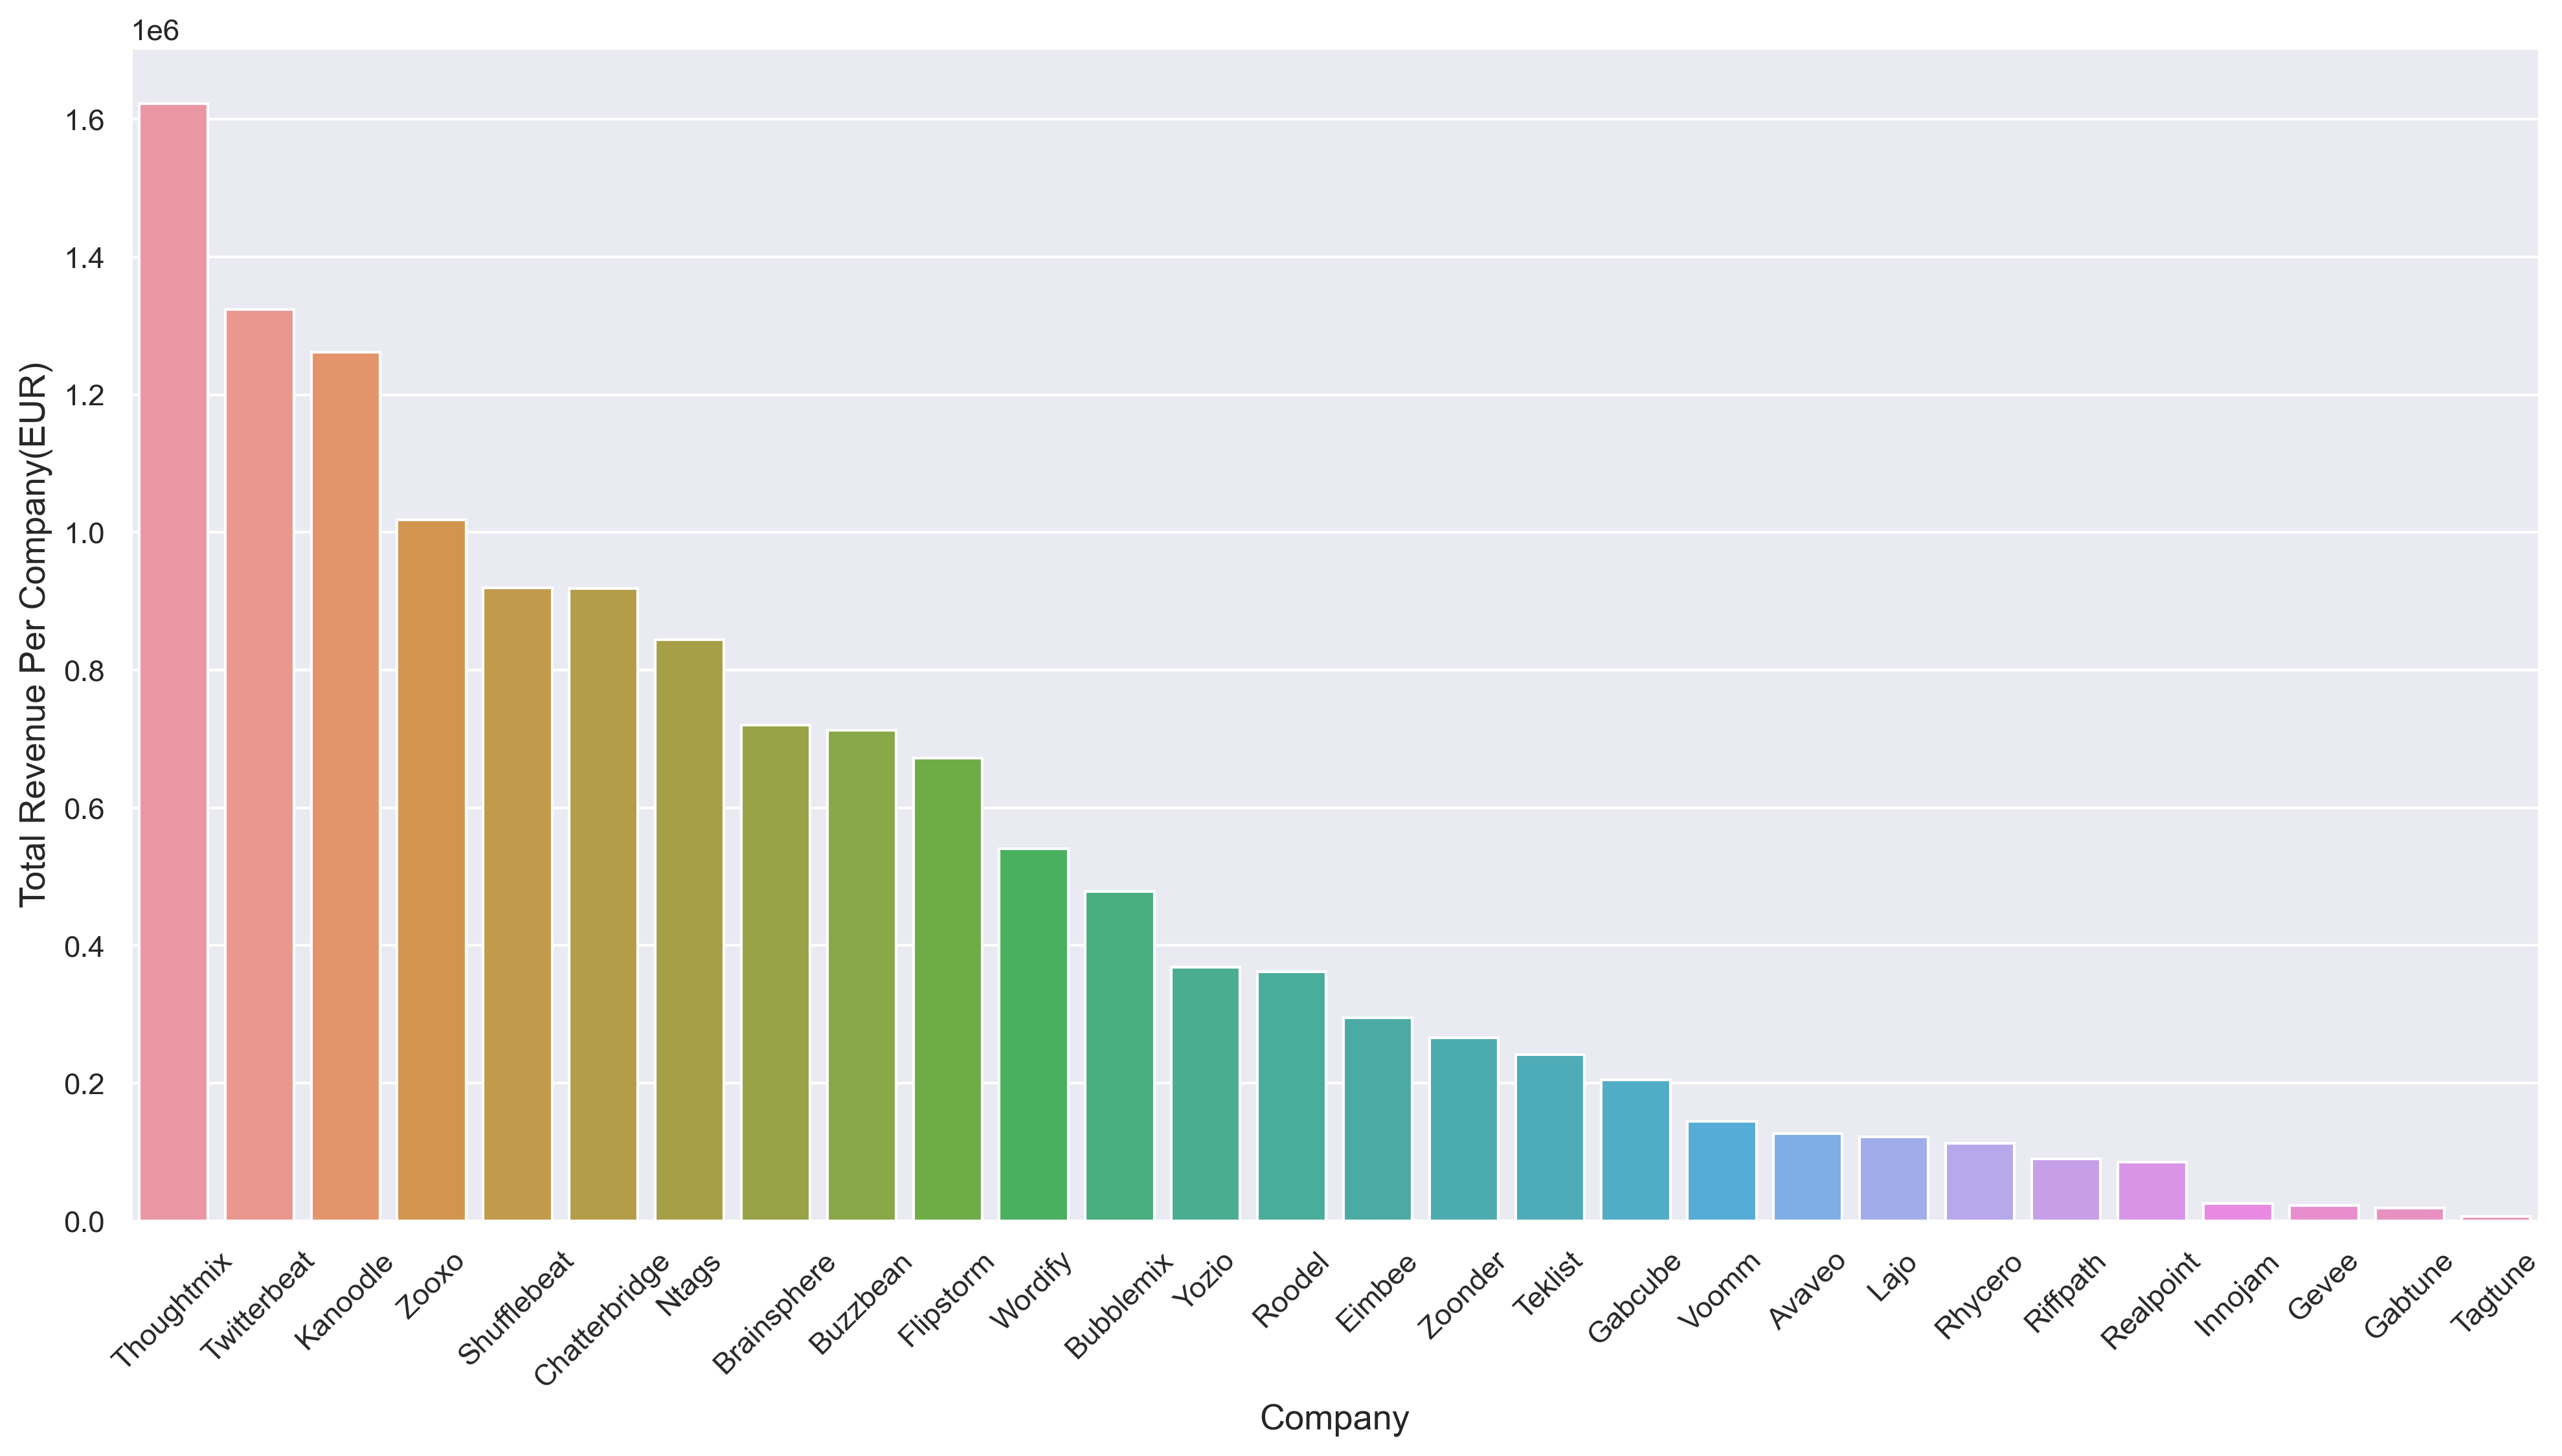

In [53]:
# your code goes here
query = psql.sqldf("""
SELECT company, 
SUM(prices_euro) AS 'revenue' 
FROM df_transactions_cleaned 
GROUP BY company 
ORDER BY revenue DESC""")

# Visulization
company_revenue = pd.DataFrame(query)
sns.set(rc={'figure.figsize':(16,8)})
plot = sns.barplot(x='company', y='revenue', data=company_revenue)
plt.xticks(rotation=45)
plt.xlabel('Company', fontsize=13)
plt.ylabel('Total Revenue Per Company(EUR)', fontsize=13)
plt.rcParams['figure.dpi'] = 300
plt.show()

### Country by revenue, per year

The revenue of a country in a time period, is its total value of orders in that time period. Compute and visualise all countries by revenue, for years 2016, 2017 and 2018. Your visualisation should have countries on the x-axis and multiple bars (one for each year).

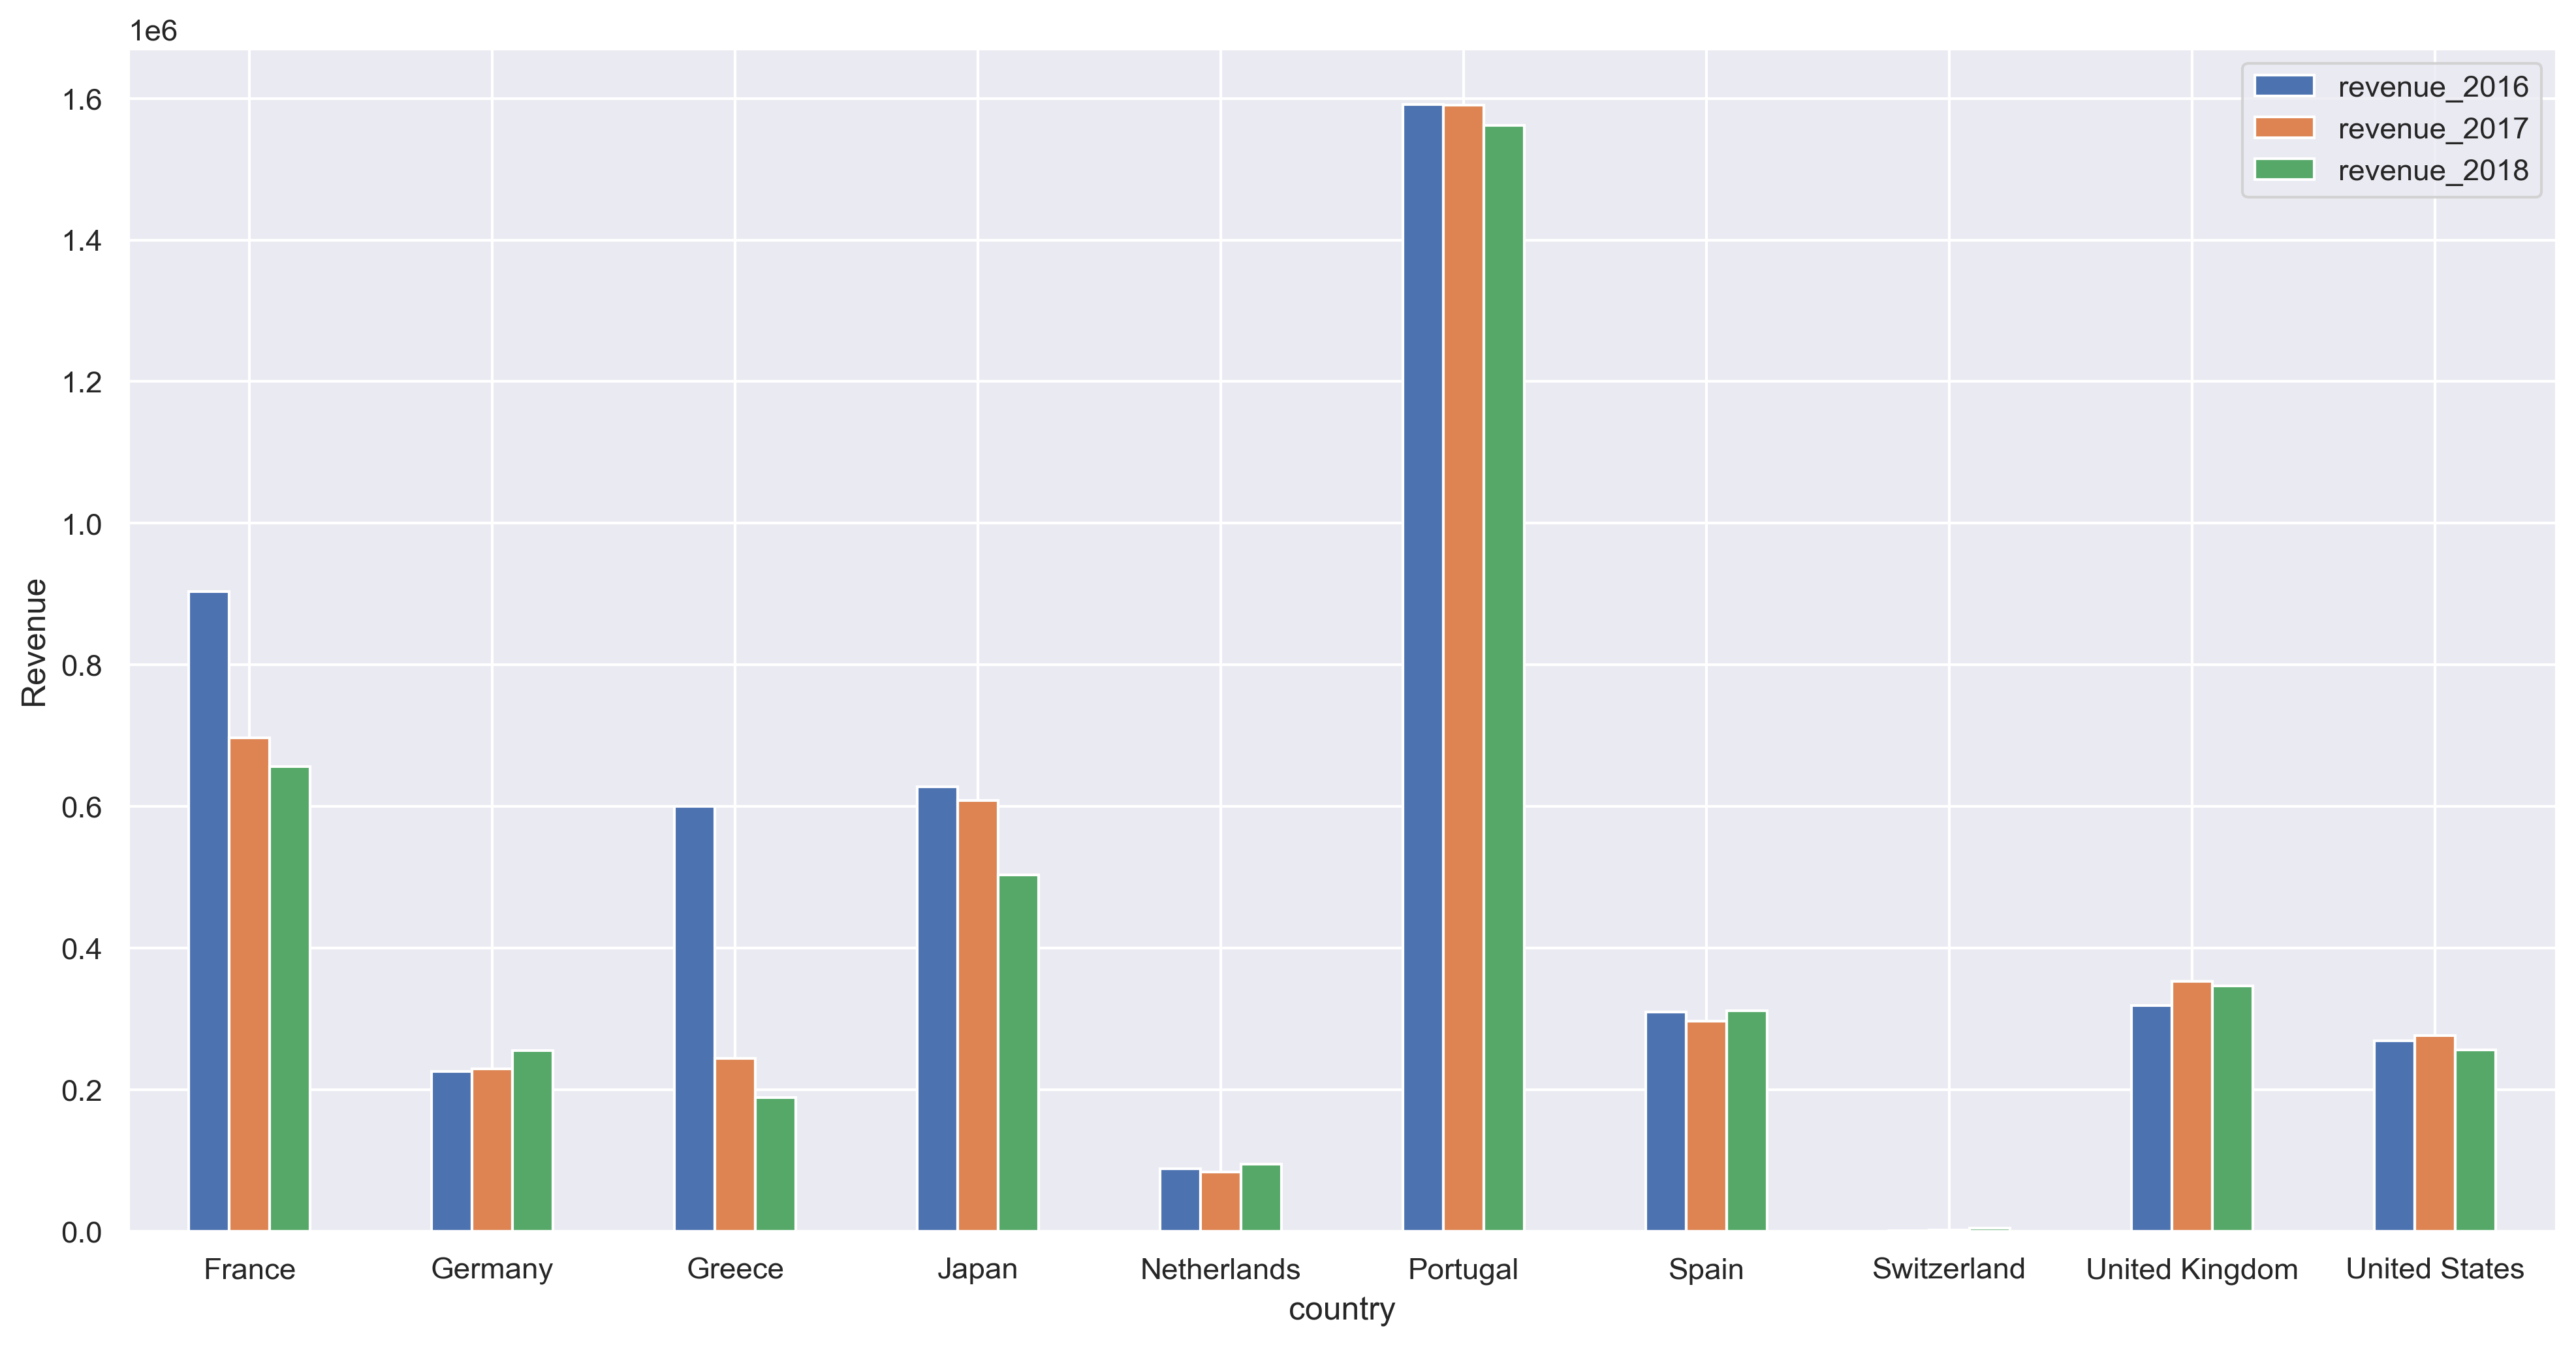

In [54]:
query = psql.sqldf("""
WITH country_revenue_2016 AS(
  SELECT country,
  SUM(prices_euro) AS 'revenue_2016'
  FROM df_transactions_cleaned
  WHERE date BETWEEN '2016-01-01' AND '2016-12-31'
  GROUP BY country),
country_revenue_2017 AS(
  SELECT country,  
  SUM(prices_euro) AS 'revenue_2017' 
  FROM df_transactions_cleaned 
  WHERE date BETWEEN '2017-01-01' AND '2017-12-31'
  GROUP BY country),
country_revenue_2018 AS(
  SELECT country,  
  SUM(prices_euro) AS 'revenue_2018' 
  FROM df_transactions_cleaned 
  WHERE date BETWEEN '2018-01-01' AND '2018-12-31'
  GROUP BY country)
SELECT *
FROM country_revenue_2016
INNER JOIN country_revenue_2017 ON country_revenue_2016.country = country_revenue_2017.country
INNER JOIN country_revenue_2018 ON country_revenue_2016.country = country_revenue_2018.country""")

# Visulization
country_revenue = pd.DataFrame(query).dropna(subset = ['country']).iloc[:, [0,1,3,5]].set_index('country')
from matplotlib import ticker

country_revenue.plot(kind='bar')

plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().xaxis.set_tick_params(rotation=0)
plt.rcParams['figure.dpi'] = 300
plt.show()

### Orders per quarter, all companies

Compute and visualise the number of orders each company has placed in each quarter. Exclude quarters where the order count is less than 3. As always, be mindful to not produce a cluttered visualisation.

Part of your query should form a variable that converts `date` into `YEAR_QUARTER` format. Dealing with dates is via `STRFTIME` [docs](https://www.sqlite.org/lang_datefunc.html) which doesn't allow quarter extraction. Instead, it allows for extraction of month, which you can case on in order to produce the quarter (Q1, Q2, Q3, Q4).  

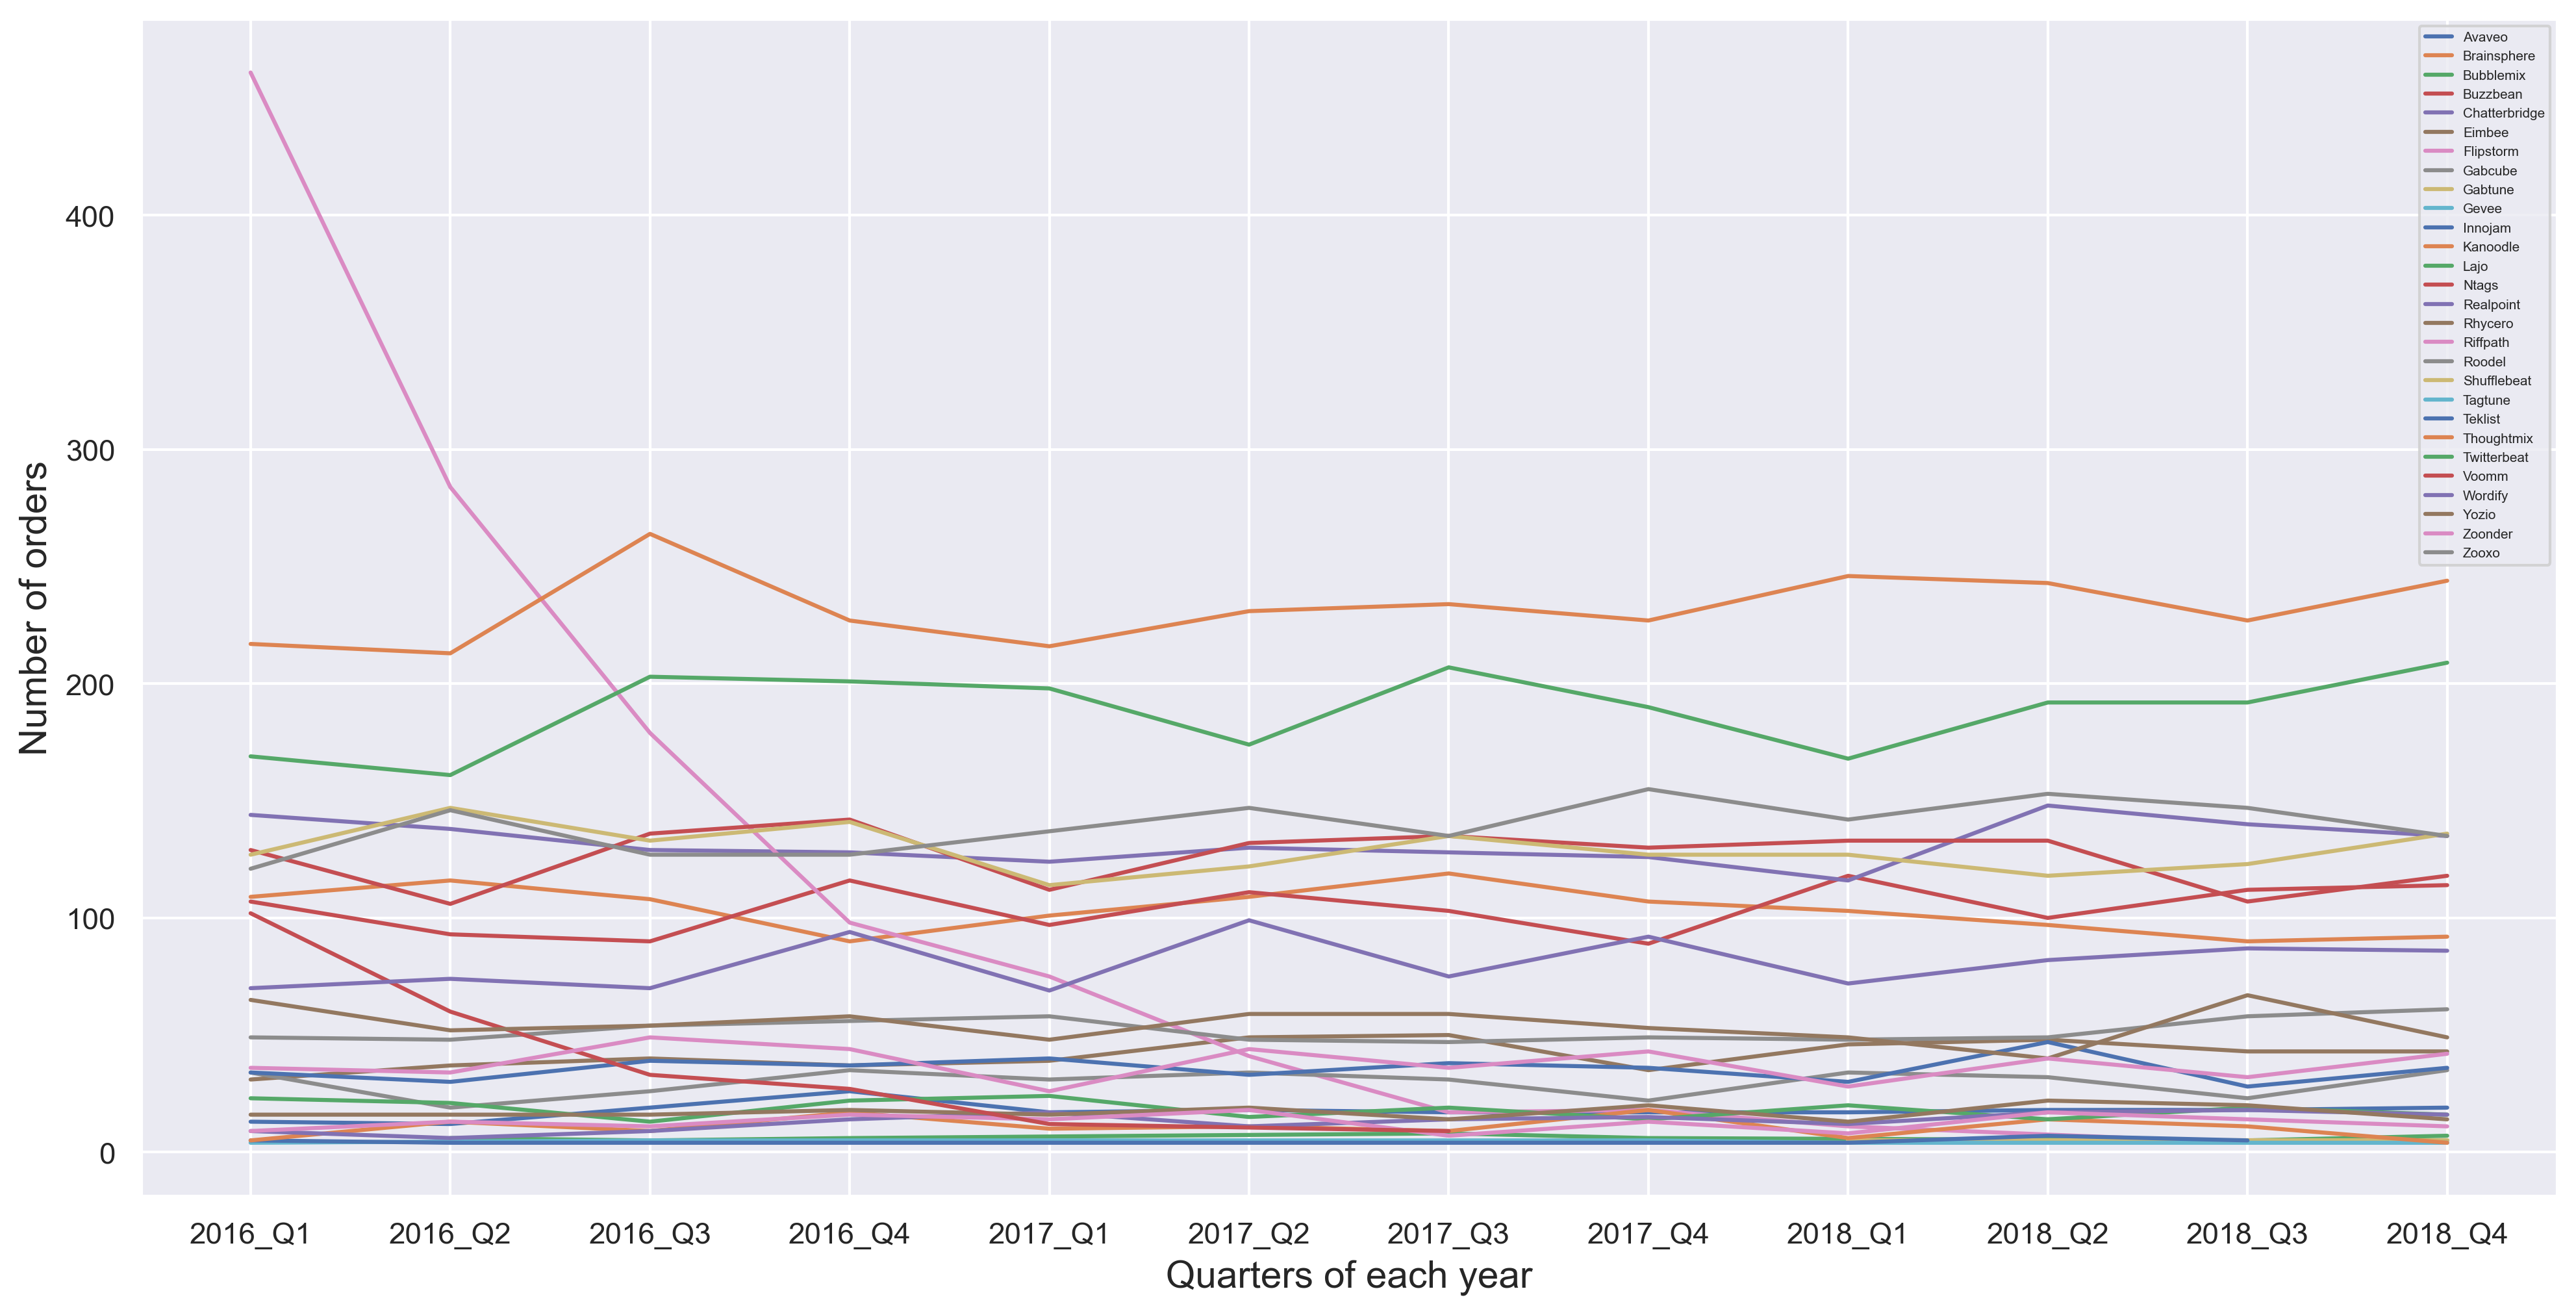

In [55]:
# your code goes here
query = psql.sqldf("""
WITH table_1 AS(
  SELECT company, price, date,
  strftime('%Y', date)|| '_Q' || ((strftime('%m', date) + 2) / 3) AS year_quarter
  FROM df_transactions_cleaned)
SELECT company, year_quarter, COUNT(price) AS orders
FROM table_1
GROUP BY company, year_quarter
HAVING orders > 3
""")

orders_quarter = pd.DataFrame(query).dropna(subset=['company'])
orders_quarter
# Visulization
fig,ax = plt.subplots()
for name in orders_quarter['company'].unique():
    ax.plot(orders_quarter[orders_quarter.company==name].year_quarter,\
            orders_quarter[orders_quarter.company==name].orders,label=name)

ax.set_xlabel("Quarters of each year", fontsize=14)
ax.set_ylabel("Number of orders", fontsize=14)
ax.legend(loc=1, fontsize=5)
plt.rcParams['figure.dpi'] = 300
plt.show()

## Part 4: Parts and prices

### Parts demand changes

A different amount of orders are placed on parts each year. The demand of a part is the number of orders placed on it. The demand change of a part is the absolute difference between its average demand in 2016/2017, and its demand in 2018.

Compute and visualise the 15 parts whose demand change has been the largest.

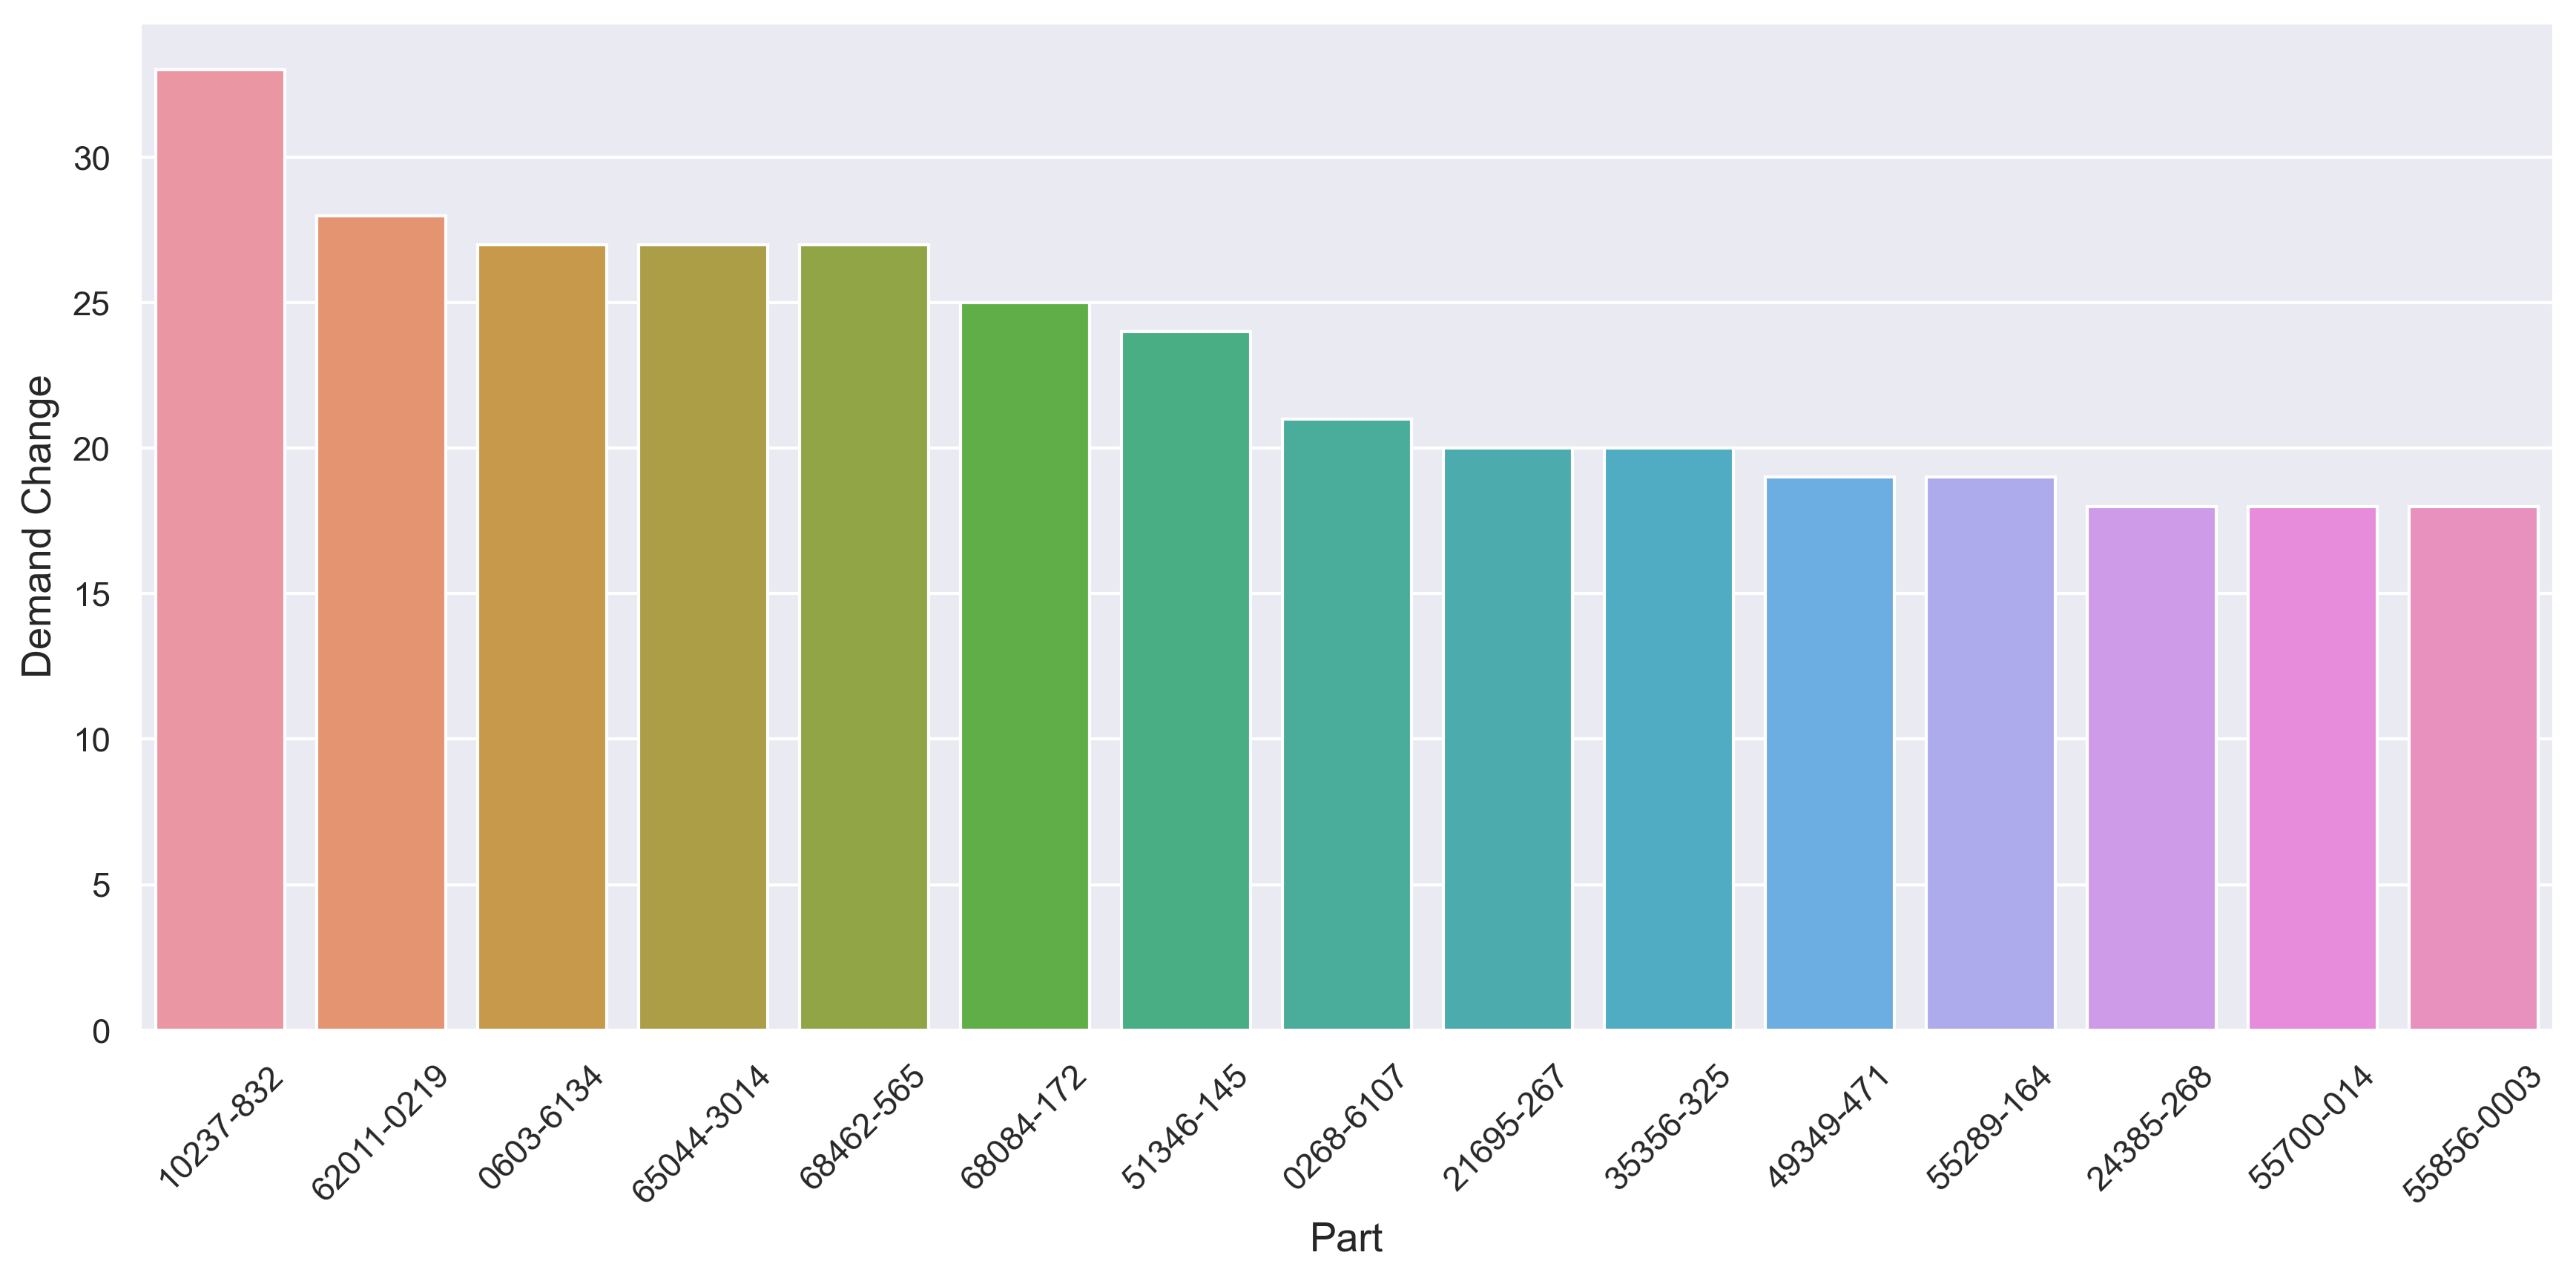

In [56]:
# your code goes here
query = psql.sqldf("""
SELECT part, ABS(demand_2018 - (demand_2017+demand_2016)/2) as demand_change
FROM (
  (SELECT t1.part AS part, t1.orders AS demand_2016, t2.orders AS demand_2017, t3.orders AS demand_2018
  FROM(
    (SELECT part, count(part) AS orders
    FROM df_transactions_cleaned
    WHERE 0+strftime('%Y', date) = 2016
    GROUP BY part
    ) AS t1,
    (
    SELECT part, count(part) AS orders
    FROM df_transactions_cleaned
    WHERE 0+strftime('%Y', date) = 2017
    GROUP BY part
    ) AS t2,
    (
    SELECT part, count(part) AS orders
    FROM df_transactions_cleaned
    WHERE 0+strftime('%Y', date) = 2018
    GROUP BY part
    ) AS t3)
  WHERE (t1.part=t2.part) and (t1.part=t3.part)
) AS t4)
ORDER BY demand_change DESC
LIMIT(15)
""")

# Visulization
df_demand_change = pd.DataFrame(query)
sns.set(rc={'figure.figsize':(14,6)})
plot = sns.barplot(x='part', y='demand_change', data=df_demand_change)
plt.xticks(rotation=45)
plt.xlabel('Part', fontsize=13)
plt.ylabel('Demand Change', fontsize=13)
plt.rcParams['figure.dpi'] = 300
plt.show()


### Popular parts pricing

The most popular parts are those whose demand has increased the most from its 2016/2017 average to 2018. We're interested to find out if popularity is due to a price drop, and also inform us if prices of these parts are properly adjusted.

The demand increase of a part is its 2018 demand minus its 2016/2017 average demand. The price change of a part is its average 2018 price minus its average 2016/2017 price.

Compute the parts whose demand has increased (has positive demand increase) and the change in price for each of these parts. Then visualise this relationship and include in the figure title the correlation (compute via pandas) between these two variables. Conclude which is most likely 1) Parts became more popular from a drop in prices, or 2) The sales department deserved its bonuses.

The Pearson correlation coefficient is -0.237426308651768


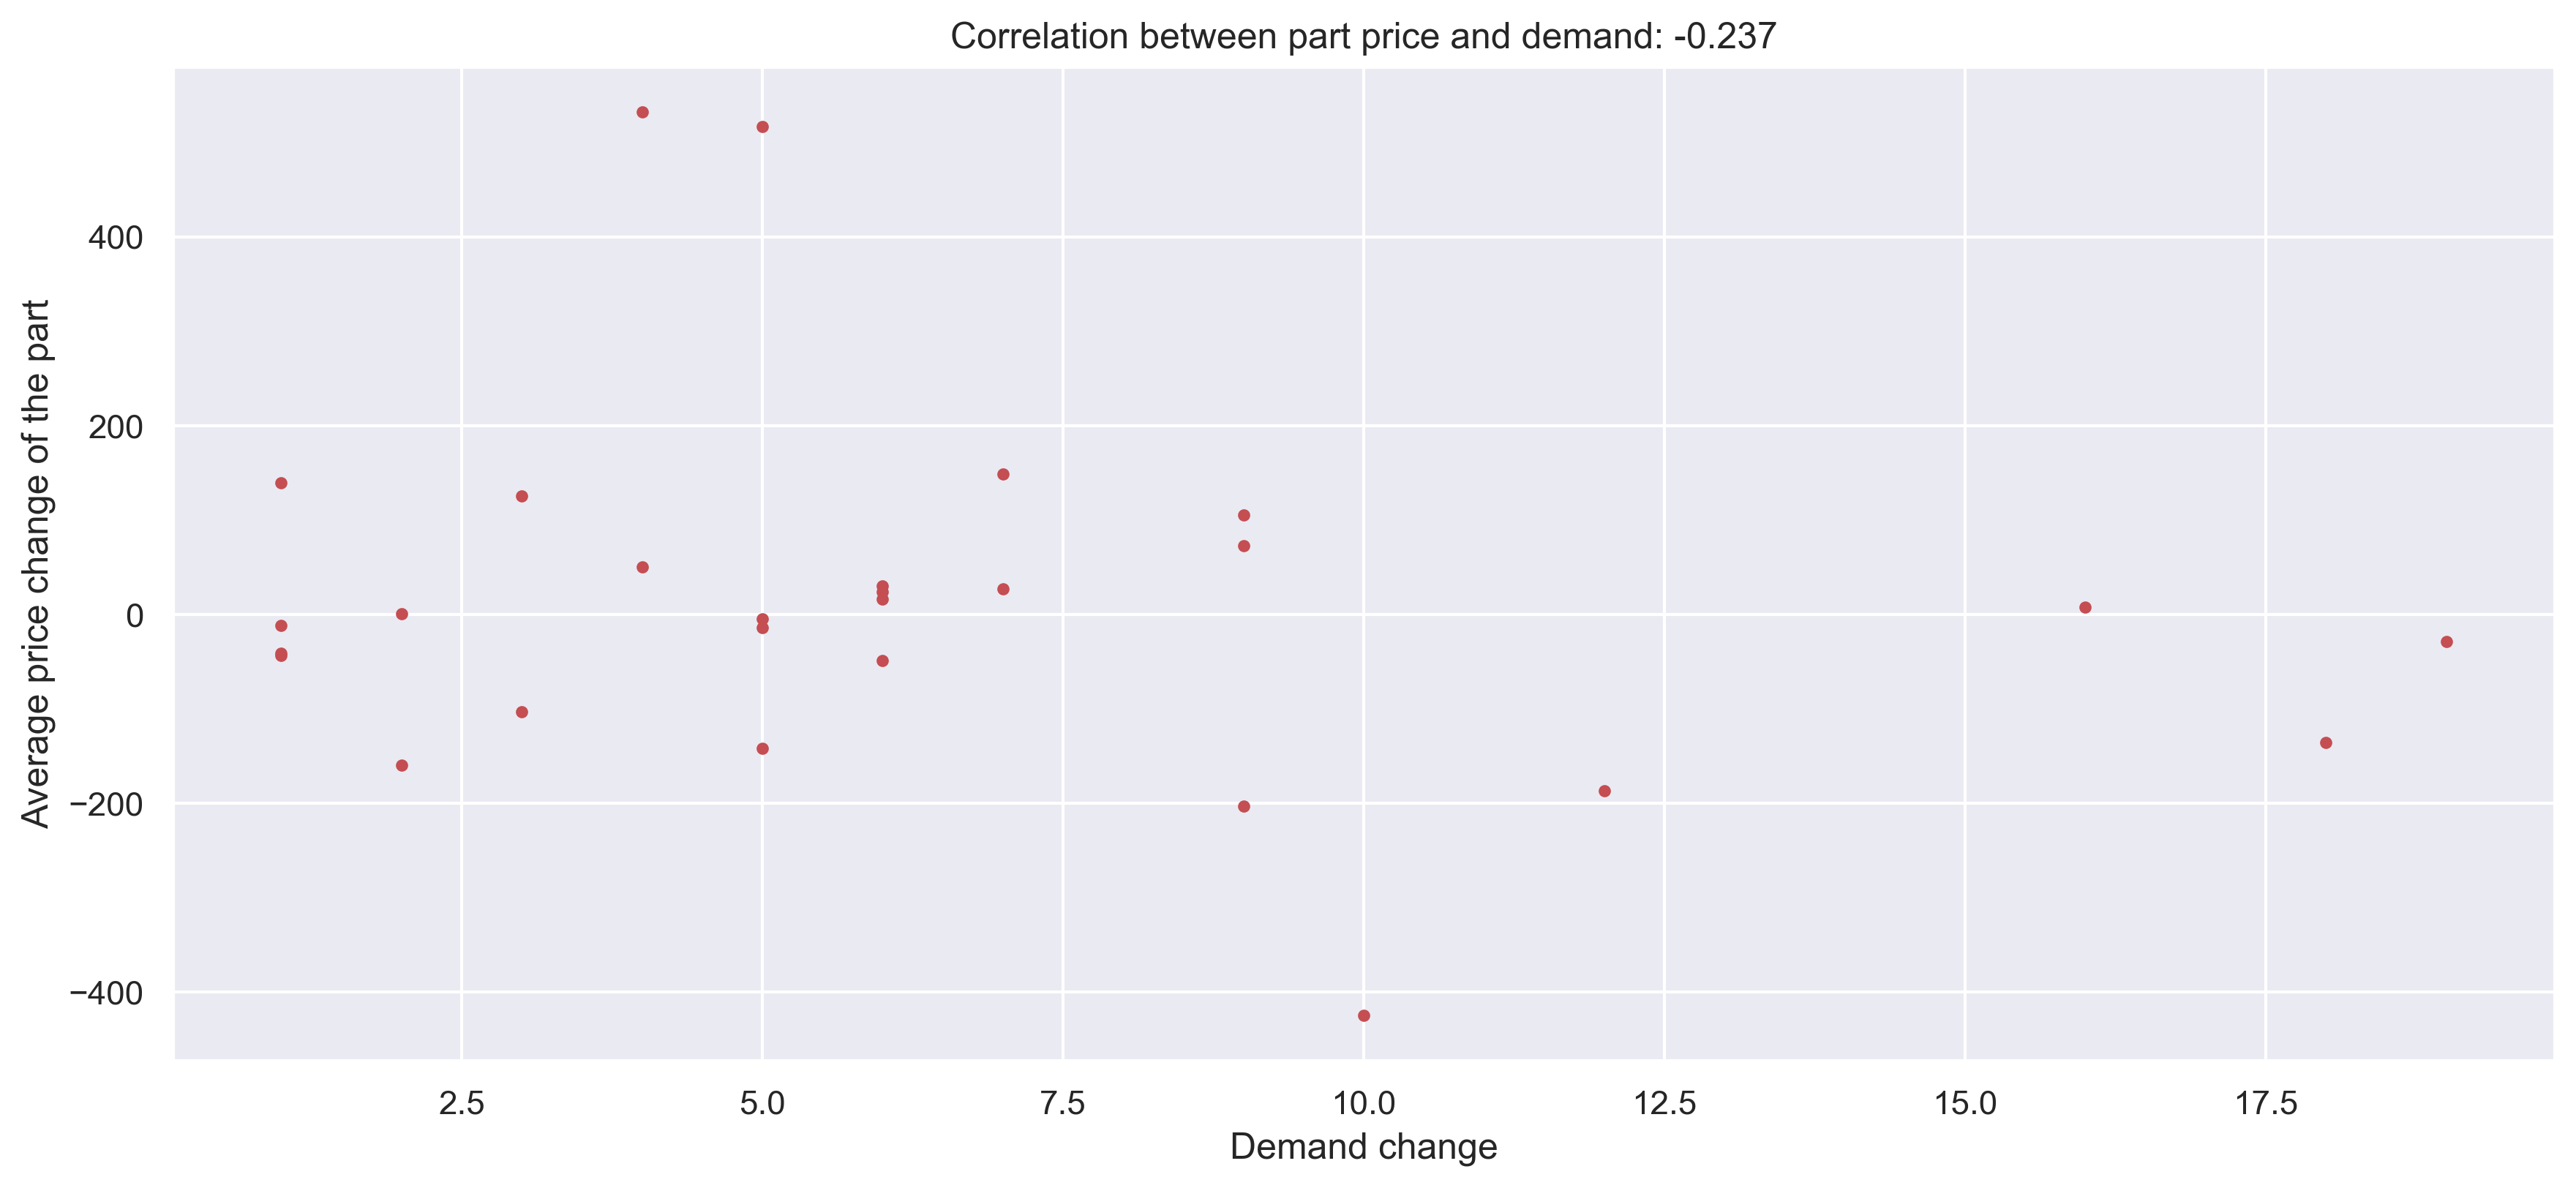

In [57]:
query = psql.sqldf("""
SELECT part,
(demand_2018 - (demand_2017+demand_2016)/2) as demand_change,
(price_2018 - (price_2017+price_2016)/2) as average_price_change
FROM (
  (SELECT t1.part AS part, t1.orders AS demand_2016, t1.avg_price AS price_2016,
          t2.orders AS demand_2017, t2.avg_price AS price_2017,
          t3.orders AS demand_2018, t3.avg_price AS price_2018
  FROM(
    (SELECT part, COUNT(part) AS orders, AVG(prices_euro) AS avg_price
    FROM df_transactions_cleaned
    WHERE 0+strftime('%Y', date) = 2016
    GROUP BY part
    ) AS t1,
    (
    SELECT part, COUNT(part) AS orders, AVG(prices_euro) AS avg_price
    FROM df_transactions_cleaned
    WHERE 0+strftime('%Y', date) = 2017
    GROUP BY part
    ) AS t2,
    (
    SELECT part, COUNT(part) AS orders, AVG(prices_euro) AS avg_price
    FROM df_transactions_cleaned
    WHERE 0+strftime('%Y', date) = 2018
    GROUP BY part
    ) AS t3)
  WHERE (t1.part=t2.part) and (t1.part=t3.part)
) AS t4)
WHERE demand_change > 0 
ORDER BY demand_change DESC
""")

# Visulization
df_demand_price = pd.DataFrame(query)
correlation = df_demand_price['average_price_change'].corr(df_demand_price['demand_change'])
print('The Pearson correlation coefficient is', correlation)
plt.figure()
plt.plot(df_demand_price['demand_change'], df_demand_price['average_price_change'], '.r')
plt.xlabel("Demand change")
plt.ylabel("Average price change of the part")
plt.title("Correlation between part price and demand: {0:.3f}".format(correlation))
plt.show()

*your explanation goes here*

The Pearson correlation coefficient between two variables is -0.24, suggesting that the increasing demand in parts has little negative correlation with the change in prices. We can also conclude from the figure that there are still several parts with increasing average price change even though the demand increases. Therefore, the reason for part prevalence is most likely that the sales department deserved its bonuses rather than drop in prices. 